# Connecting Spectra to Mocks

The purpose of this notebook is to demonstrate how to generate spectra and apply target selection cuts for various mock catalogs and target types.  Here we generate spectra for targets in a single healpixel with no constraints on the target density (relative to the expected target density) or contaminants.

For code to generate large numbers of spectra over significant patches of sky and to create a representative DESI dataset (with parallelism), see `desitarget/bin/select_mock_targets` (as well as its MPI-parallelized cousin, `desitarget/bin/select_mock_targets`) and `desitarget.mock.build.targets_truth`.

Finally, note that the various python Classes instantiated here (documented in `desitarget.mock.mockmaker`) are easily extensible to other mock catalogs and galaxy/QSO/stellar physics.  Please contact @desi-data if you have specific suggestions, requirements, or desired features.

John Moustakas  
Siena College  
2018 September

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from desiutil.log import get_logger, DEBUG
log = get_logger()

In [3]:
import seaborn as sns
sns.set(style='white', font_scale=1.1, palette='Set2')

In [4]:
%matplotlib inline

#### To keep the calculations below manageable we specify a single nside=64 healpixel in an arbitrary location of the DESI footprint.

In [5]:
healpixel = 26030
nside = 64

#### Specifying the random seed makes our calculations reproducible.

In [6]:
seed = 555
rand = np.random.RandomState(seed)

#### Define a couple wrapper routines we will use below several times.

In [7]:
def plot_subset(wave, flux, truth, objtruth, nplot=16, ncol=4, these=None, 
                xlim=None, loc='right', targname='', objtype=''):
    """Plot a random sampling of spectra."""
    
    nspec, npix = flux.shape
    if nspec < nplot:
        nplot = nspec
    
    nrow = np.ceil(nplot / ncol).astype('int')

    if loc == 'left':
        xtxt, ytxt, ha = 0.05, 0.93, 'left'
    else:
        xtxt, ytxt, ha = 0.93, 0.93, 'right'
    
    if these is None:
        these = rand.choice(nspec, nplot, replace=False)
        these = np.sort(these)
        
    ww = (wave > 5500) * (wave < 5550)

    fig, ax = plt.subplots(nrow, ncol, figsize=(2.5*ncol, 2*nrow), sharey=False, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :] / np.median(flux[indx, ww]))
        if objtype == 'STAR' or objtype == 'WD':
            thisax.text(xtxt, ytxt, r'$T_{{eff}}$={:.0f} K'.format(objtruth['TEFF'][indx]), 
                        ha=ha, va='top', transform=thisax.transAxes, fontsize=13)
        else:
            thisax.text(xtxt, ytxt, 'z={:.3f}'.format(truth['TRUEZ'][indx]), 
                        ha=ha, va='top', transform=thisax.transAxes, fontsize=13)
            
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        if xlim:
            thisax.set_xlim(xlim)
    for thisax in ax.flat:
        thisax.yaxis.set_ticks([])
        thisax.margins(0.2)
        
    fig.suptitle(targname)
    fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.93)

### Tracer QSOs

Both tracer and Lya QSO spectra contain an underlying QSO spectrum, but the Lya QSOs (which we demonstrate below) also include the Lya forest (here, based on the v2.0 of the "London" mocks).

#### Every target class has its own dedicated "Maker" class.

In [8]:
from desitarget.mock.mockmaker import QSOMaker

In [9]:
QSO = QSOMaker(seed=seed)

#### The various `read` methods return a dictionary with (hopefully self-explanatory) target- and mock-specific quantities.

Because most mock catalogs only come with (cosmologically accurate) 3D positions (RA, Dec, redshift), we use Gaussian mixture models trained on real data to assign other quantities like shapes, magnitudes, and colors, depending on the target class.  For more details see the [gmm-dr7.pynb](https://github.com/desihub/desitarget/blob/master/doc/nb/gmm-dr7.ipynb) Python notebook.

In [10]:
dir(QSOMaker)

['GMM_BGS',
 'GMM_ELG',
 'GMM_LRG',
 'GMM_QSO',
 'GMM_nospectra',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_qaplot_scatter_photometry',
 '_query',
 '_sample_vdisp',
 'deredden',
 'imaging_depth',
 'is_south',
 'make_spectra',
 'mock_density',
 'mw_transmission',
 'populate_targets_truth',
 'qamock_sky',
 'read',
 'read_GMM',
 'sample_GMM',
 'sample_gmm_nospectra',
 'scatter_photometry',
 'select_targets',
 'template_maker',
 'wave']

In [11]:
data = QSO.read(healpixels=healpixel, nside=nside)

INFO:mockmaker.py:204:_get_radec: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.8_2LPT/QSO.fits
INFO:mockmaker.py:209:_get_radec: Assigning healpix pixels with nside = 64.
INFO:mockmaker.py:1013:readmock: Trimmed to 278 QSOs in 1 healpixel(s)


In [12]:
for key in sorted(list(data.keys())):
    print('{:>20}'.format(key))

             BRICKID
           BRICKNAME
                 DEC
                 EBV
             FRACDEV
        FRACDEV_IVAR
          GALDEPTH_G
          GALDEPTH_R
          GALDEPTH_Z
                  GR
             HEALPIX
                 MAG
           MAGFILTER
          MOCKFORMAT
              MOCKID
   MW_TRANSMISSION_G
   MW_TRANSMISSION_R
  MW_TRANSMISSION_W1
  MW_TRANSMISSION_W2
   MW_TRANSMISSION_Z
               NSIDE
          PSFDEPTH_G
          PSFDEPTH_R
         PSFDEPTH_W1
         PSFDEPTH_W2
          PSFDEPTH_Z
                  RA
                  RZ
         SHAPEDEV_E1
    SHAPEDEV_E1_IVAR
         SHAPEDEV_E2
    SHAPEDEV_E2_IVAR
          SHAPEDEV_R
     SHAPEDEV_R_IVAR
         SHAPEEXP_E1
    SHAPEEXP_E1_IVAR
         SHAPEEXP_E2
    SHAPEEXP_E2_IVAR
          SHAPEEXP_R
     SHAPEEXP_R_IVAR
               SOUTH
         TARGET_NAME
                TYPE
              WEIGHT
                   Z
             Z_NORSD


#### Now we can generate the spectra as well as the targeting catalogs (`targets`) and corresponding truth table.

In [13]:
%time flux, wave, targets, truth, objtruth = QSO.make_spectra(data)

CPU times: user 23.3 s, sys: 613 ms, total: 23.9 s
Wall time: 8.82 s


In [14]:
print(flux.shape, wave.shape)

(278, 32001) (32001,)


The *truth* catalog contains the target-type-agnostic, known properties of each object (including the noiseless photometry), while the *objtruth* catalog contains different information depending on the type of target.

In [15]:
truth

TARGETID,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,MAGFILTER,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2
,,,,,,,,,mag,,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies
int64,int64,int64,float32,str10,str10,str10,int32,int64,float32,str15,float32,float32,float32,float32,float32
0,805003,0,0.064521514,QSO,QSO,,0,3083073946,21.958181,decam2014-r,1.3155252,1.6471289,1.3978552,9.353628,12.184755
1,806867,0,0.24405892,QSO,QSO,,1,3083073946,20.454065,decam2014-r,6.668142,6.582241,6.631145,36.949104,54.179123
2,806871,0,0.21123381,QSO,QSO,,2,3083073946,20.292582,decam2014-r,6.5492663,7.6377854,8.046796,43.78626,59.71899
3,806872,0,0.20261684,QSO,QSO,,3,3083073946,19.66041,decam2014-r,10.597002,13.672118,14.281725,80.23975,97.031166
4,806873,0,0.20218813,QSO,QSO,,4,3083073946,21.565155,decam2014-r,2.1882048,2.3655822,3.0843112,26.268179,34.804714
5,807790,0,0.21745251,QSO,QSO,,5,3083073946,19.89786,decam2014-r,9.057861,10.986411,12.397997,91.397934,116.50557
6,808667,0,0.30863097,QSO,QSO,,6,3083073946,22.050121,decam2014-r,1.3007828,1.5133926,2.029872,11.565333,13.796736
7,808688,0,0.23844679,QSO,QSO,,7,3083073946,21.332415,decam2014-r,2.742029,2.9311233,2.8146992,12.80661,19.582201


In [16]:
objtruth

TARGETID,MABS_1450,SLOPES [5],"EMLINES [62,3]",BAL_TEMPLATEID,TRUEZ_NORSD
,mag,,,,
int64,float32,float32,float32,int16,float32
0,-14.047102,-1.7129928 .. -0.835502,1035.3782 .. 302.12286,-1,0.06341781
1,-19.65603,-1.2781011 .. -1.2105631,1033.8455 .. 342.85593,-1,0.24462861
2,-18.670444,-1.0837291 .. -0.98093325,1035.0521 .. 320.38995,-1,0.21144317
3,-18.695759,-1.6943103 .. -0.60000336,1035.274 .. 288.70416,-1,0.20239617
4,-17.668034,-1.7412169 .. -0.88925403,1034.4237 .. 305.43887,-1,0.20181188
5,-18.94463,-2.0057101 .. -0.7667627,1034.5592 .. 310.20236,-1,0.21832864
6,-17.924303,-1.7918501 .. -0.5499107,1034.4136 .. 282.07452,-1,0.30772457
7,-18.33521,-1.4819869 .. -1.3435807,1034.0651 .. 300.91568,-1,0.2385634


#### Next, let's run target selection, after which point the targets catalog should look just like an imaging targeting catalog (here, using the DR7 data model).

In [17]:
QSO.select_targets(targets, truth)

In [18]:
targets

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,EBV,PHOTSYS,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,PRIORITY,SUBPRIORITY,NUMOBS,HPXPIXEL
,,,,,deg,deg,1 / deg2,1 / deg2,,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,1/nanomaggies^2,1/nanomaggies^2,1/nanomaggies^2,1/nanomaggies^2,1/nanomaggies^2,,,,,,,,,,,,,,,,,,1/nanomaggies^2,1/nanomaggies^2,1/nanomaggies^2,1/nanomaggies^2,1/nanomaggies^2,1/nanomaggies^2,,,arcsec,1 / arcsec2,,,,,arcsec,1 / arcsec2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,int32,str8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,float32,bytes1,int64,int64,int64,int64,int64,float64,int64,int64
9999,338388,2051p012,0,PSF,205.01565551757812,1.1642898321151733,100000000.0,100000000.0,0.0 .. 400.0,1.2284315,1.4624544,1.3795735,8.687934,11.800566,1312.0187,193.17015,46.76705,0.691831,10.964782,0.93089974,0.95291144,0.9731644,0.9959091,0.9974857,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.480747,7.7268057,1.8706821,57.543995,13.182568,2.5118864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,1.0,0.0,1.0,0.0,1.0,False,0.02418877,S,0,263172,0,0,0,0.0,0,0
9999,335506,2046p007,0,PSF,204.60443115234375,0.6952595114707947,100000000.0,100000000.0,0.0 .. 400.0,6.1568203,6.2272353,6.287642,37.95033,53.790924,1312.0187,193.17015,46.76705,0.691831,10.964782,0.9219694,0.9467439,0.9696071,0.99535966,0.9971477,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.480747,7.7268057,1.8706821,57.543995,13.182568,2.5118864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,1.0,0.0,1.0,0.0,1.0,False,0.027445143,S,0,263172,0,0,0,0.0,0,0
9999,335505,2043p007,0,PSF,204.3285369873047,0.8382059931755066,100000000.0,100000000.0,0.0 .. 400.0,6.073138,7.4628944,8.018667,43.85394,59.817078,1312.0187,193.17015,46.76705,0.691831,10.964782,0.93157005,0.95337355,0.9734305,0.99595016,0.9975109,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.480747,7.7268057,1.8706821,57.543995,13.182568,2.5118864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,1.0,0.0,1.0,0.0,1.0,False,0.023945604,S,0,263172,0,0,0,0.0,0,0
9999,335507,2048p007,0,PSF,204.8030242919922,0.7743522524833679,100000000.0,100000000.0,0.0 .. 400.0,9.828876,13.052356,14.076743,81.26294,96.48409,1312.0187,193.17015,46.76705,0.691831,10.964782,0.9269181,0.95016396,0.971581,0.9956648,0.9973354,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.480747,7.7268057,1.8706821,57.543995,13.182568,2.5118864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.

#### And indeed, we can see that only a subset of the QSOs were identified as targets (the rest scattered out of the QSO color selection boxes).

In [19]:
from desitarget.targetmask import desi_mask
isqso = (targets['DESI_TARGET'] & desi_mask.QSO) != 0
print('Identified {} / {} QSO targets.'.format(np.count_nonzero(isqso), len(targets)))

Identified 270 / 278 QSO targets.


#### Finally, let's plot some example spectra.

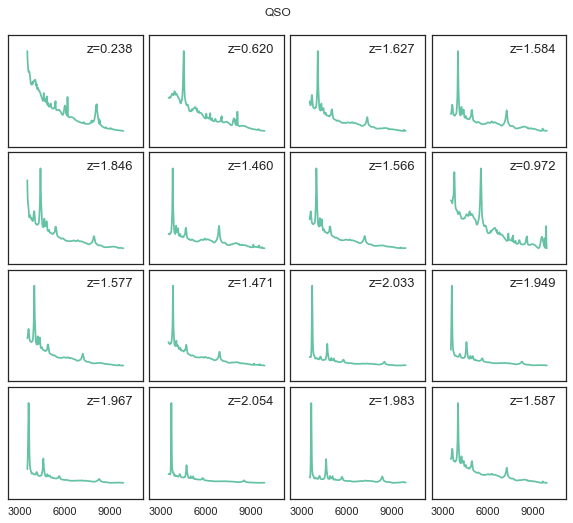

In [21]:
plot_subset(wave, flux, truth, objtruth, targname='QSO')

### Generating QSO spectra with cosmological Lya skewers proceeds along similar lines.

Here, we also include BALs with 15% probability.

In [22]:
from desitarget.mock.mockmaker import LYAMaker

In [23]:
LYA = LYAMaker(seed=seed, balprob=0.25)

INFO:io.py:937:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.6/bal_templates_v2.0.fits


In [24]:
lyadata = LYA.read(healpixels=healpixel, nside=nside)

INFO:mockmaker.py:1517:readmock: Reading /Users/ioannis/work/desi/mocks/lya_forest/london/v2.0/master.fits
INFO:mockmaker.py:1537:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:1550:readmock: Trimmed to 174 LYAs in 1 healpixel(s)


In [25]:
%time lyaflux, lyawave, lyatargets, lyatruth, lyaobjtruth = LYA.make_spectra(lyadata)

CPU times: user 17.7 s, sys: 648 ms, total: 18.3 s
Wall time: 6.47 s


In [26]:
lyaobjtruth

TARGETID,MABS_1450,SLOPES [5],"EMLINES [62,3]",BAL_TEMPLATEID,TRUEZ_NORSD
,mag,,,,
int64,float32,float32,float32,int16,float32
0,-22.508553,-1.1839224 .. -0.77932775,1034.4103 .. 275.93246,-1,2.3369708
1,-23.99229,-0.9632328 .. -1.2974983,1033.3716 .. 293.263,364,2.929899
2,-24.171434,-1.9502937 .. -0.83108777,1034.3984 .. 277.39706,-1,1.9048676
3,-22.556812,-1.1963991 .. -1.2611578,1034.7963 .. 260.8861,-1,2.2060978
4,-23.49757,-1.5108017 .. -1.1400044,1033.7954 .. 309.3529,-1,2.5021372
5,-23.822346,-1.7499807 .. -1.4893066,1034.0289 .. 267.75156,40,2.1867871
6,-25.045292,-1.5004028 .. -1.5808194,1033.6466 .. 289.3879,-1,2.2021272
7,-25.199411,-1.479645 .. -1.173443,1033.3171 .. 264.47433,-1,2.6486742


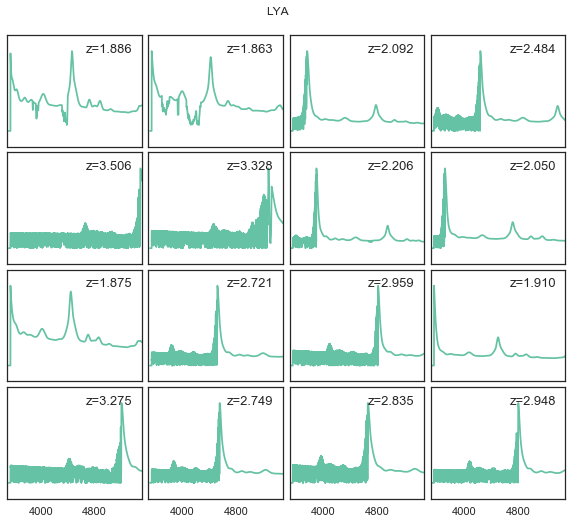

In [28]:
plot_subset(lyawave, lyaflux, lyatruth, objtruth, xlim=(3500, 5500), targname='LYA')

### Demonstrate the other extragalactic target classes: LRG, ELG, and BGS.

For simplicity let's write a little wrapper script that does all the key steps.

In [29]:
def demo_mockmaker(Maker, seed=None, nrand=16, loc='right'):

    TARGET = Maker(seed=seed)
    
    log.info('Reading the mock catalog for {}s'.format(TARGET.objtype))
    tdata = TARGET.read(healpixels=healpixel, nside=nside)
    
    log.info('Generating {} random spectra.'.format(nrand))
    indx = rand.choice(len(tdata['RA']), np.min( (nrand, len(tdata['RA'])) ) )
    tflux, twave, ttargets, ttruth, tobjtruth = TARGET.make_spectra(tdata, indx=indx)
    
    log.info('Selecting targets')
    TARGET.select_targets(ttargets, ttruth)
    
    plot_subset(twave, tflux, ttruth, tobjtruth, loc=loc, 
                targname=tdata['TARGET_NAME'], objtype=TARGET.objtype)

#### LRGs

In [30]:
from desitarget.mock.mockmaker import LRGMaker

INFO:io.py:937:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.6/lrg_templates_v2.0.fits
INFO:<ipython-input-29-4a2e37d4263e>:5:demo_mockmaker: Reading the mock catalog for LRGs
INFO:mockmaker.py:204:_get_radec: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.8_2LPT/LRG.fits
INFO:mockmaker.py:209:_get_radec: Assigning healpix pixels with nside = 64.
INFO:mockmaker.py:1013:readmock: Trimmed to 780 LRGs in 1 healpixel(s)
INFO:<ipython-input-29-4a2e37d4263e>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-29-4a2e37d4263e>:12:demo_mockmaker: Selecting targets
CPU times: user 11.6 s, sys: 1.34 s, total: 13 s
Wall time: 8.41 s


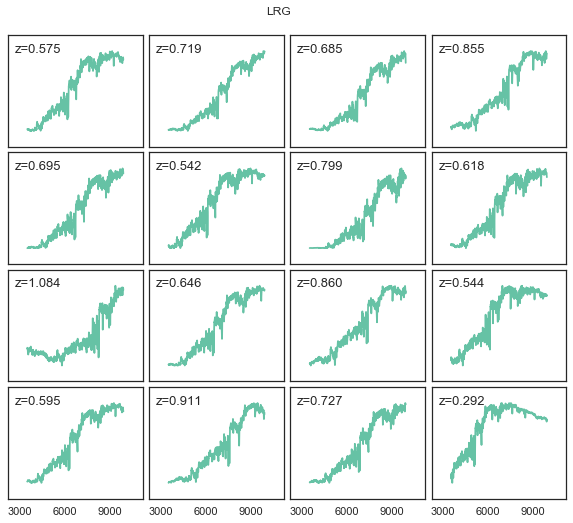

In [31]:
%time demo_mockmaker(LRGMaker, seed=seed, loc='left')

#### ELGs

In [32]:
from desitarget.mock.mockmaker import ELGMaker

INFO:io.py:937:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.6/elg_templates_v2.0.fits
INFO:<ipython-input-29-4a2e37d4263e>:5:demo_mockmaker: Reading the mock catalog for ELGs
INFO:mockmaker.py:204:_get_radec: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.8_2LPT/ELG.fits
INFO:mockmaker.py:209:_get_radec: Assigning healpix pixels with nside = 64.
INFO:mockmaker.py:1013:readmock: Trimmed to 4029 ELGs in 1 healpixel(s)
INFO:<ipython-input-29-4a2e37d4263e>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-29-4a2e37d4263e>:12:demo_mockmaker: Selecting targets
CPU times: user 22.4 s, sys: 9.19 s, total: 31.5 s
Wall time: 27.2 s


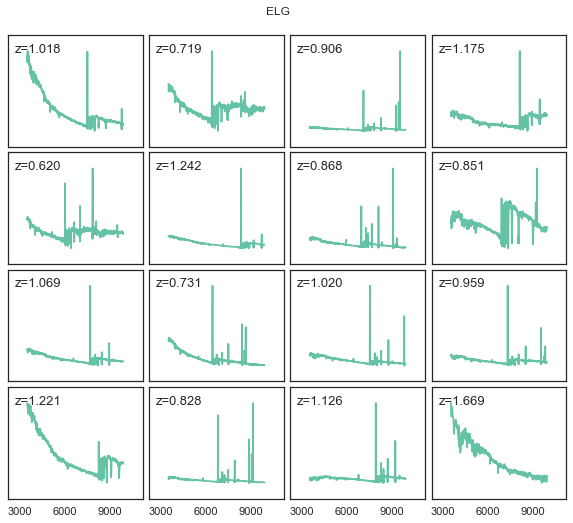

In [33]:
%time demo_mockmaker(ELGMaker, seed=seed, loc='left')

#### BGS

In [34]:
from desitarget.mock.mockmaker import BGSMaker

INFO:io.py:937:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.6/bgs_templates_v2.1.fits
INFO:<ipython-input-29-4a2e37d4263e>:5:demo_mockmaker: Reading the mock catalog for BGSs
INFO:mockmaker.py:1702:_read_mockfile: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:1734:readmock: Trimmed to 2338 BGSs in 1 healpixel(s).
INFO:<ipython-input-29-4a2e37d4263e>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-29-4a2e37d4263e>:12:demo_mockmaker: Selecting targets
CPU times: user 23.5 s, sys: 4.17 s, total: 27.7 s
Wall time: 20.2 s


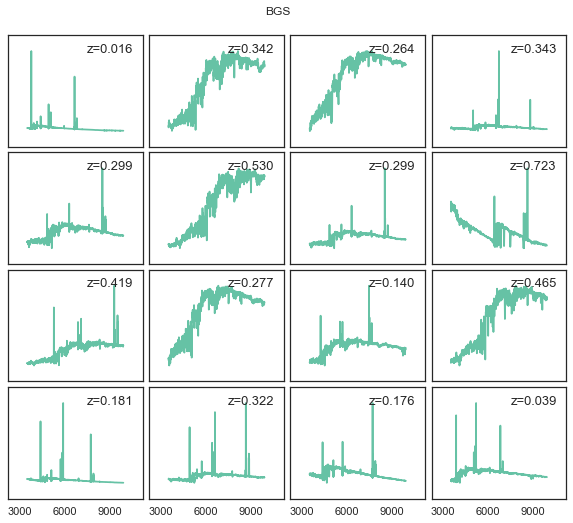

In [35]:
%time demo_mockmaker(BGSMaker, seed=seed)

### Next, demonstrate how to generate spectra of stars...

#### MWS_MAIN

In [36]:
from desitarget.mock.mockmaker import MWS_MAINMaker

INFO:io.py:937:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.6/star_templates_v2.2.fits
INFO:<ipython-input-29-4a2e37d4263e>:5:demo_mockmaker: Reading the mock catalog for STARs
INFO:mockmaker.py:1291:readmock: Reading /Users/ioannis/work/desi/mocks/mws/galaxia/alpha/v0.0.5/healpix/8/4/406/mock_allsky_galaxia_desi-8-406.fits
INFO:<ipython-input-29-4a2e37d4263e>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-29-4a2e37d4263e>:12:demo_mockmaker: Selecting targets
INFO:mockmaker.py:3712:select_targets: Temporarily turning off contaminants.
CPU times: user 8.71 s, sys: 3.99 s, total: 12.7 s
Wall time: 12 s


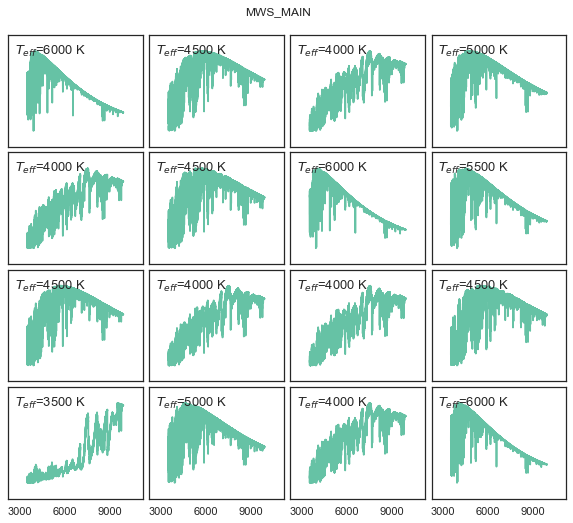

In [37]:
%time demo_mockmaker(MWS_MAINMaker, seed=seed, loc='left')

#### MWS_NEARBY

In [38]:
from desitarget.mock.mockmaker import MWS_NEARBYMaker

INFO:<ipython-input-29-4a2e37d4263e>:5:demo_mockmaker: Reading the mock catalog for STARs
INFO:mockmaker.py:204:_get_radec: Reading /Users/ioannis/work/desi/mocks/mws/100pc/v0.0.3/mock_100pc.fits
INFO:mockmaker.py:209:_get_radec: Assigning healpix pixels with nside = 64.
INFO:mockmaker.py:2136:readmock: Trimmed to 7 MWS_NEARBYs in 1 healpixel(s).
INFO:<ipython-input-29-4a2e37d4263e>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-29-4a2e37d4263e>:12:demo_mockmaker: Selecting targets
CPU times: user 4.32 s, sys: 204 ms, total: 4.52 s
Wall time: 3.02 s


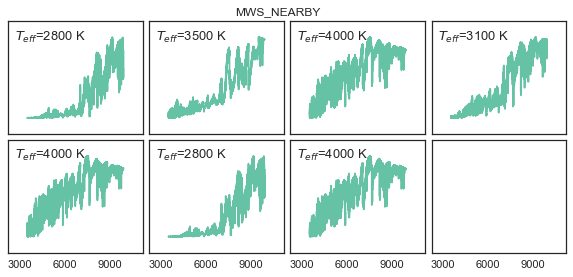

In [39]:
%time demo_mockmaker(MWS_NEARBYMaker, seed=seed, loc='left')

#### White dwarfs (WDs)

In [40]:
from desitarget.mock.mockmaker import WDMaker

INFO:io.py:937:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.6/wd_templates_v2.1.fits
INFO:io.py:937:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.6/wd_templates_v2.1.fits
INFO:<ipython-input-29-4a2e37d4263e>:5:demo_mockmaker: Reading the mock catalog for WDs
INFO:mockmaker.py:204:_get_radec: Reading /Users/ioannis/work/desi/mocks/mws/wd/v0.0.2/mock_wd.fits
INFO:mockmaker.py:209:_get_radec: Assigning healpix pixels with nside = 64.
INFO:mockmaker.py:2012:readmock: Trimmed to 12 WDs in 1 healpixel(s).
INFO:<ipython-input-29-4a2e37d4263e>:8:demo_mockmaker: Generating 16 random spectra.
INFO:<ipython-input-29-4a2e37d4263e>:12:demo_mockmaker: Selecting targets
CPU times: user 5.78 s, sys: 354 ms, total: 6.14 s
Wall time: 3.44 s


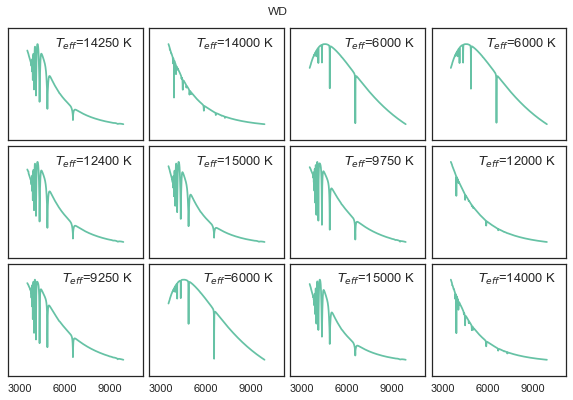

In [41]:
%time demo_mockmaker(WDMaker, seed=seed, loc='right')

### Finally demonstrate how to generate (empyt) SKY spectra.

In [42]:
from desitarget.mock.mockmaker import SKYMaker

In [43]:
SKY = SKYMaker(seed=seed)

In [44]:
skydata = SKY.read(healpixels=healpixel, nside=nside)

INFO:mockmaker.py:204:_get_radec: Reading /Users/ioannis/work/desi/mocks/uniformsky/0.1/uniformsky-2048-0.1.fits
INFO:mockmaker.py:209:_get_radec: Assigning healpix pixels with nside = 64.
INFO:mockmaker.py:1158:readmock: Trimmed to 1024 SKYs in 1 healpixel(s).


In [45]:
skyflux, skywave, skytargets, skytruth, objtruth = SKY.make_spectra(skydata)

In [46]:
SKY.select_targets(skytargets, skytruth)